In [7]:
import torch

from src.model.models import DWSModelForClassification
from src.data.datasets import ModelDataset

from src.model.layers.layers import NaiveInvariantLayer

from src.model.models import DWSModelForClassification

from src.data.datasets import Batch
from src.model.layers.layers import WeightToWeightBlock, BiasToBiasBlock, BiasToWeightBlock, DWSLayer, InvariantLayer, NaiveInvariantLayer



## Small model to experiment with

In [2]:
class M(torch.nn.Module):
    def __init__(self):
        super(M, self).__init__()
        self.fc = torch.nn.Linear(1, 2)
        self.fc2 = torch.nn.Linear(2, 2)
        self.fc3 = torch.nn.Linear(2, 1)

    def forward(self, x):
        return x
    
class M2(torch.nn.Module):
    def __init__(self):
        super(M2, self).__init__()
        self.fc = torch.nn.Linear(1, 2)
        self.fc3 = torch.nn.Linear(2, 1)

    def forward(self, x):
        return x

In [3]:
def reduction(x: torch.tensor, dim=1, keepdim=False):
    x, _ = torch.max(x, dim=dim, keepdim=keepdim)
    return x

In [13]:
torch.random.manual_seed(0)
model = M()
state_dict = model.state_dict()
weights = tuple(
    [v.permute(1, 0) for w, v in state_dict.items() if "weight" in w]
)
biases = tuple([v for w, v in state_dict.items() if "bias" in w])
label = 1
# add feature dim
weights = tuple([w.unsqueeze(-1) for w in weights])
biases = tuple([b.unsqueeze(-1) for b in biases])

weights = tuple([w.unsqueeze(0) for w in weights])
biases = tuple([b.unsqueeze(0) for b in biases])


batch = Batch(weights=weights, biases=biases, label=label)

input = (batch.weights, batch.biases)

weights, biases = input
pooled_weights = torch.cat(
    [
        reduction(w.permute(0, 3, 1, 2).flatten(start_dim=2), dim=2)
        for w in weights
    ],
    dim=-1,
)  # (bs, len(weights) * in_features)
pooled_biases = torch.cat(
    [reduction(b, dim=1) for b in biases], dim=-1
)  # (bs, len(biases) * in_features)
pooled_all = torch.cat(
    [pooled_weights, pooled_biases], dim=-1
)  # (bs, num layers * in_features)
# out = self.layer(pooled_all)

print(pooled_weights)
print(pooled_biases)
print(pooled_all)

tensor([[ 0.5364,  0.5607, -0.1390]])
tensor([[-0.7359,  0.1871, -0.6755]])
tensor([[ 0.5364,  0.5607, -0.1390, -0.7359,  0.1871, -0.6755]])


In [14]:
torch.random.manual_seed(0)
model = M()
state_dict = model.state_dict()
weights = tuple(
    [v.permute(1, 0) for w, v in state_dict.items() if "weight" in w]
)
biases = tuple([v for w, v in state_dict.items() if "bias" in w])
label = 1
# add feature dim
weights = tuple([w.unsqueeze(-1) for w in weights])
biases = tuple([b.unsqueeze(-1) for b in biases])

weights = tuple([w.unsqueeze(0) for w in weights])
biases = tuple([b.unsqueeze(0) for b in biases])


batch = Batch(weights=weights, biases=biases, label=label)

input = (batch.weights, batch.biases)

weight_shapes = tuple(w.shape[:2] for w in batch.weights)
bias_shapes = tuple(b.shape[:1] for b in batch.biases)


weights, biases = input
# first and last matrices are special
first_w, last_w = weights[0], weights[-1]
# first w is of shape (bs, d0, d1, in_features)
# (bs, d1, d0 * in_features)
pooled_first_w = first_w.permute(0, 2, 1, 3).flatten(start_dim=2)
# (bs, d{L-1}, dL * in_features)
pooled_last_w = last_w.flatten(start_dim=2)
# (bs, d0 * in_features)
pooled_first_w = reduction(pooled_first_w, dim=1)
# (bs, dL * in_features)
pooled_last_w = reduction(pooled_last_w, dim=1)
# last bias is special
last_b = biases[-1]
# (bs, dL * in_features)
pooled_last_b = last_b.flatten(start_dim=1)

# concat
pooled_weights = torch.cat(
    [
        reduction(w.permute(0, 3, 1, 2).flatten(start_dim=2), dim=2)
        for w in weights[1:-1]
    ],
    dim=-1,
)  # (bs, (len(weights) - 2) * in_features)
# (bs, (len(weights) - 2) * in_features + d0 * in_features + dL * in_features)
pooled_weights = torch.cat(
    (pooled_weights, pooled_first_w, pooled_last_w), dim=-1
)

pooled_biases = torch.cat(
    [reduction(b, dim=1) for b in biases[:-1]], dim=-1
)  # (bs, (len(biases) - 1) * in_features)
# (bs, (len(biases) - 1) * in_features + dL * in_features)
pooled_biases = torch.cat((pooled_biases, pooled_last_b), dim=-1)

pooled_all = torch.cat(
    [pooled_weights, pooled_biases], dim=-1
)  # (bs, (num layers - 3) * in_features + d0 * in_features + dL * in_features + dL * in_features)
print(weights)
print(pooled_weights)
print(pooled_biases)
print(pooled_all)


(tensor([[[[-0.0075],
          [ 0.5364]]]]), tensor([[[[-0.2723],
          [-0.0140]],

         [[ 0.1896],
          [ 0.5607]]]]), tensor([[[[-0.2137]],

         [[-0.1390]]]]))
tensor([[ 0.5607,  0.5364, -0.1390]])
tensor([[-0.7359,  0.1871, -0.6755]])
tensor([[ 0.5607,  0.5364, -0.1390, -0.7359,  0.1871, -0.6755]])


## DWSLayer

In [161]:
# Init model

torch.random.manual_seed(0)
model = M()
state_dict = model.state_dict()
weights = tuple(
    [v.permute(1, 0) for w, v in state_dict.items() if "weight" in w]
)
biases = tuple([v for w, v in state_dict.items() if "bias" in w])
label = 1
# add feature dim
weights = tuple([w.unsqueeze(-1) for w in weights])
biases = tuple([b.unsqueeze(-1) for b in biases])

weight_shapes = tuple(w.shape[:2] for w in weights)
bias_shapes = tuple(b.shape[:1] for b in biases)

weights = tuple([w.unsqueeze(0) for w in weights])
biases = tuple([b.unsqueeze(0) for b in biases])

input = (batch.weights, batch.biases)


In [31]:
print(weight_shapes)
print(weights)

(torch.Size([1, 2]), torch.Size([2, 2]), torch.Size([2, 1]))
(tensor([[[[-0.0075],
          [ 0.5364]]]]), tensor([[[[-0.2723],
          [-0.0140]],

         [[ 0.1896],
          [ 0.5607]]]]), tensor([[[[-0.2137]],

         [[-0.1390]]]]))


In [116]:
from copy import deepcopy
weights2 = deepcopy(weights)
biases2 = deepcopy(biases)

weights2[0][0][0][0][0] = weights[0][0][0][1][0]
weights2[0][0][0][1][0] = weights[0][0][0][0][0]

weights2[1][0][0] = weights[1][0][1]
weights2[1][0][1] = weights[1][0][0]

biases2[0][0][0][0] = biases[0][0][1][0]
biases2[0][0][1][0] = biases[0][0][0][0]

In [85]:
torch.random.manual_seed(0)

wtow = WeightToWeightBlock(1, 32, weight_shapes, True)
btb = BiasToBiasBlock(1, 32, bias_shapes, True)
btw = BiasToWeightBlock(1, 12, weight_shapes, bias_shapes, True)

out = wtow(weights)
print(out)


(tensor([[[[-0.6655, -0.1010,  1.8620, -0.2286, -1.5704,  1.7401,  1.1177,
            3.0300,  2.0010, -0.2726,  1.2527,  2.7540,  2.6377,  2.5384,
            0.4597, -0.2522, -1.4785, -1.0100,  2.6784, -0.8543,  3.4108,
           -0.0341, -0.3370,  0.7219,  0.5718,  1.4856,  0.7458,  0.2948,
            0.2504, -1.4303,  0.9109, -1.6496],
          [-0.4206, -0.2908,  0.9121, -0.2833, -1.4716,  2.1465,  1.0656,
            2.9322,  1.7172, -0.6533,  1.0977,  2.7765,  2.5596,  3.0215,
            0.0173,  0.3705, -1.5881, -0.8808,  3.5059, -1.6990,  2.9269,
           -0.5795, -0.6970,  0.5768,  0.3230,  1.8542,  0.4305,  0.2948,
            0.1383, -1.5371,  0.9999, -2.3654]]]], grad_fn=<AddBackward0>), tensor([[[[-0.7910,  0.7848, -0.4902, -0.9995, -1.2310, -0.2963,  1.0588,
           -0.3151,  2.1650,  0.0609,  0.3034,  0.5415,  2.5995,  2.2518,
            1.9877,  0.1646,  0.0591,  3.3048, -0.3364,  1.6045,  2.4406,
           -2.5121, -0.1624,  1.5654, -0.3500, -1.9686,  2.69

In [148]:
torch.random.manual_seed(0)

model = DWSModelForClassification(weight_shapes, bias_shapes, 1, 32)
input = (weights, biases)
out = model(input)
print(out)

tensor([[-0.0597,  0.0090,  0.0118,  0.0103,  0.0660, -0.0623,  0.0173,  0.0516,
          0.0492, -0.0629]], grad_fn=<AddmmBackward0>)


In [4]:
torch.random.manual_seed(0)

model = M2()
state_dict = model.state_dict()
weights = tuple(
    [v.permute(1, 0) for w, v in state_dict.items() if "weight" in w]
)
biases = tuple([v for w, v in state_dict.items() if "bias" in w])
label = 1
# add feature dim
weights = tuple([w.unsqueeze(-1) for w in weights])
biases = tuple([b.unsqueeze(-1) for b in biases])

weight_shapes = tuple(w.shape[:2] for w in weights)
bias_shapes = tuple(b.shape[:1] for b in biases)

weights = tuple([w.unsqueeze(0) for w in weights])
biases = tuple([b.unsqueeze(0) for b in biases])

layer = DWSLayer(weight_shapes, bias_shapes, 1, 16, True)
input = (weights, biases)
out = layer(input)

# weights, biases = out
# # first and last matrices are special
# first_w, last_w = weights[0], weights[-1]
# # first w is of shape (bs, d0, d1, in_features)
# # (bs, d1, d0 * in_features)
# pooled_first_w = first_w.permute(0, 2, 1, 3).flatten(start_dim=2)
# # (bs, d{L-1}, dL * in_features)
# pooled_last_w = last_w.flatten(start_dim=2)
# # (bs, d0 * in_features)
# pooled_first_w = reduction(pooled_first_w, dim=1)
# # (bs, dL * in_features)
# pooled_last_w = reduction(pooled_last_w, dim=1)
# # last bias is special

layer = NaiveInvariantLayer(weight_shapes, bias_shapes, 16, 16, True)
out = layer(out)
print(out)

tensor([[ 0.0675,  0.0363,  0.0755,  0.0618,  0.0639,  0.0710, -0.1068, -0.0936,
          0.0637,  0.0882, -0.0142,  0.0372,  0.0235,  0.0825, -0.0144,  0.0453]],
       grad_fn=<AddmmBackward0>)


In [5]:
from copy import deepcopy

weights2 = deepcopy(weights)
biases2 = deepcopy(biases)

weights2[0][0][0][0][0] = weights[0][0][0][1][0]
weights2[0][0][0][1][0] = weights[0][0][0][0][0]

weights2[1][0][1][0][0] = weights[1][0][0][0][0]
weights2[1][0][0][0][0] = weights[1][0][1][0][0]

biases2[0][0][0][0] = biases[0][0][1][0]
biases2[0][0][1][0] = biases[0][0][0][0]


In [21]:
torch.random.manual_seed(0)
model = DWSModelForClassification(weight_shapes, bias_shapes, 1, 16, 2, 5, set_layer="ds")
input = (weights, biases)
out = model(input)
print(out)

tensor([[ 0.0071,  0.0437, -0.0867,  0.0077,  0.0379]],
       grad_fn=<AddmmBackward0>)


In [42]:
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np

In [43]:
save_path = Path("../data") / "data.pt"
models_path = Path("../models/eight_angles_small")
batches = []
for p in tqdm(list(models_path.glob("*.pth"))):
    angle = int(p.stem.split("_")[-2])

    state_dict = torch.load(p, map_location=lambda storage, loc: storage)
    weights = tuple(
        [v.permute(1, 0) for w, v in state_dict.items() if "weight" in w]
    )
    biases = tuple([v for w, v in state_dict.items() if "bias" in w])
    label = angle

    # add feature dim
    weights = tuple([w.unsqueeze(-1) for w in weights])
    biases = tuple([b.unsqueeze(-1) for b in biases])

    row = np.array([weights, biases, label])
    print(row)
    break

batches = torch.tensor(batches)
with open(save_path, "w") as file:
    torch.save(batches, file)

  0%|          | 0/80000 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

## Equivariant autoencoder

In [75]:
class EquivariantAutoencoder(torch.nn.Module):
    def __init__(self, weight_shapes, bias_shapes, in_features, out_features, num_classes, num_layers):
        super(EquivariantAutoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            DWSLayer(weight_shapes, bias_shapes, 1, 16),
            NaiveInvariantLayer(weight_shapes, bias_shapes, 16, 16),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [57]:
from src.data.datasets import ModelDataset
from torch.utils.data import DataLoader

In [80]:
torch.random.manual_seed(0)

dataset = ModelDataset("../data/dataset_splits.json")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

sample = dataset[0]
weight_shapes = tuple(w.shape[:2] for w in sample.weights)
bias_shapes = tuple(b.shape[:1] for b in sample.biases)

model = EquivariantAutoencoder(weight_shapes, bias_shapes, 1, 16, 2, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for batch in dataloader:
    input = (batch.weights, batch.biases)
    out = model(input)
    print(out)
    break

tensor([[-0.0544, -0.0272,  0.0062, -0.0176,  0.0138, -0.0104, -0.0131,  0.0038,
         -0.0272, -0.0118, -0.0296, -0.0005,  0.0297,  0.0279,  0.0188,  0.0033,
          0.0338, -0.0165,  0.0362,  0.0378, -0.0336, -0.0251, -0.0286,  0.0151,
          0.0156, -0.0086,  0.0122, -0.0234,  0.0182,  0.0184, -0.0097, -0.0148,
         -0.0016]], grad_fn=<AddmmBackward0>)


In [85]:
from src.model.layers.base import SAB, SetLayer


In [153]:
torch.random.manual_seed(0)
l1 = SAB(1, 2, 1)
l2 = SetLayer(1, 2, True, "max")

x = torch.tensor([[[1.0], [2.0]]])
out = l1(x)
print(out)

out = l2(x)
print(out)

tensor([[[-0.1388,  0.8081],
         [-0.3963,  1.3684]]], grad_fn=<AddBackward0>)
tensor([[[ 0.0969, -1.1017],
         [-0.5811, -1.5372]]], grad_fn=<SubBackward0>)


## Try SAB and SetLayer

In [2]:
from src.model.layers.base import SAB, SetLayer
from src.data.datasets import ModelParamsDataset

import torch
import torch.nn as nn
import math
import torch.nn.functional as F

import pandas as pd

from tqdm.notebook import tqdm

from src.model.models import MLP
from src.data.helpers import list_to_model, get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [7]:
class InvariantAutoencoder(nn.Module):
    def __init__(self) -> None:
        super(InvariantAutoencoder, self).__init__()

        self.sab1 = SetLayer(1, 1024)
        self.sab2 = SetLayer(1024, 512)
        self.sab3 = SetLayer(512, 256)
        self.sab4 = SetLayer(256, 128)

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )
    
    def forward(self, x):
        x = self.sab1(x)
        x = self.sab2(x)
        x = self.sab3(x)
        x = self.sab4(x)
        x = torch.sum(x, dim=1)
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [8]:
config = {
    "model":{
        "name": "InvariantAutoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 150,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

model = InvariantAutoencoder()
model.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

path = f"../models/autoencoders/equivariant"

In [247]:
model.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        input = X.unsqueeze(-1)
        output = model(input)

        loss = loss_fn(output, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(model.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(model.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1, Loss: 4.872636318206787
Epoch: 6, Loss: 4.996645927429199
Epoch: 11, Loss: 5.09433126449585
Epoch: 16, Loss: 4.9892497062683105
Epoch: 21, Loss: 4.89255428314209
Epoch: 26, Loss: 4.948014736175537
Epoch: 31, Loss: 4.879665851593018
Epoch: 36, Loss: 4.9720540046691895
Epoch: 41, Loss: 5.036984920501709
Epoch: 46, Loss: 4.970928192138672
Epoch: 51, Loss: 5.006242752075195
Epoch: 56, Loss: 5.039368629455566
Epoch: 61, Loss: 5.024776458740234
Epoch: 66, Loss: 5.009047031402588
Epoch: 71, Loss: 4.961163520812988
Epoch: 76, Loss: 5.065025329589844
Epoch: 81, Loss: 5.056278228759766
Epoch: 86, Loss: 5.015213489532471
Epoch: 91, Loss: 5.0517401695251465
Epoch: 96, Loss: 4.9483256340026855
Epoch: 101, Loss: 5.0681023597717285
Epoch: 106, Loss: 5.020676612854004
Epoch: 111, Loss: 5.036560535430908
Epoch: 116, Loss: 5.003661632537842
Epoch: 121, Loss: 5.03764009475708
Epoch: 126, Loss: 4.921196937561035
Epoch: 131, Loss: 4.947547435760498
Epoch: 136, Loss: 5.021877288818359
Epoch: 141, 

C:\Projects\Python\master-thesis\src\data\helpers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data = torch.tensor(parameters_from_list, dtype=torch.float32).reshape(param.shape)


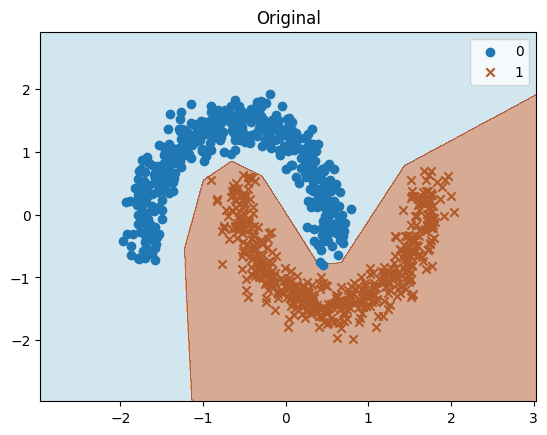

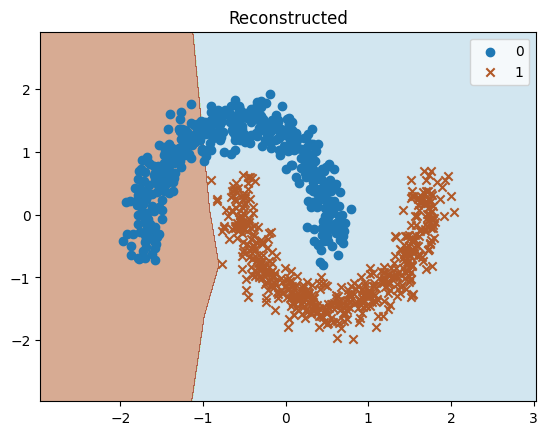

In [103]:
model = SetTransformer(1, 33, 1)
model.load_state_dict(torch.load("{}/autoencoder_final.pth".format(path)))
model.eval()
model1 = MLP(2, [8], 1)
model2 = MLP(2, [8], 1)

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()
X,y = get_moons_dataset()

index = 1000
X_rotated = rotate(X, angles[index])
w = torch.tensor(weights[index])

o = model(w.unsqueeze(0).unsqueeze(-1)).squeeze().detach().numpy()
list_to_model(model1, w)
list_to_model(model2, o)

plot_decision_boundary(model1, X_rotated, y, title="Original")
plot_decision_boundary(model2, X_rotated, y, title="Reconstructed")

## My implementation of DeepSets

In [35]:
from src.model.layers.base import SAB, SetLayer
from src.data.datasets import ModelParamsDataset

import torch
import torch.nn as nn
import math
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [63]:
class FeatureExtractor(nn.Module):
    def __init__(self, in_features, out_features, n_fc_layers = 1) -> None:
        super(FeatureExtractor, self).__init__()
        layers = [nn.Linear(in_features, out_features)]
        for _ in range(n_fc_layers-1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(out_features, out_features))

        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        x = self.fc(x)
        return x
    
class InvariantEncoder(nn.Module):
    def __init__(self, in_features, out_features, n_fc_layers = 1, pooling = "sum") -> None:
        super(InvariantEncoder, self).__init__()
        self.features_extractor = FeatureExtractor(in_features, out_features, n_fc_layers)
        self.pooling = pooling

    def forward(self, x):
        features = self.features_extractor(x)
        if(self.pooling == "sum"):
            pooled_features = torch.sum(features, dim=1)
        else:
            raise NotImplementedError("Pooling method not implemented")
        return pooled_features


class Encoder(nn.Module):
    def __init__(self, in_features, out_features, num_classes = 8, n_fc_layers=1):
        super(Encoder, self).__init__()
        self.invariant_encoder = InvariantEncoder(in_features, out_features, n_fc_layers)
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(out_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        pooled_features = self.invariant_encoder(x)
        output = self.encoder(pooled_features)
        output = self.softmax(output)
        return output
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )
    
    def forward(self, x):
        x = self.decoder(x)
        return x

class InvariantAutoencoder(nn.Module):
    def __init__(self, in_features, out_features, n_fc_layers = 2) -> None:
        super(InvariantAutoencoder, self).__init__()
        self.encoder = Encoder(in_features, out_features, n_fc_layers)
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [64]:
config = {
    "model":{
        "name": "InvariantAutoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

model = Encoder(1, 1024, 8, 5)
model.to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

path = f"../models/autoencoders/equivariant"

In [65]:
model.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        X = X.unsqueeze(-1)
        output = model(X)

        loss = loss_fn(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {i+1}, Loss: {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3341688811779022
Epoch: 2, Loss: 0.33659499883651733
Epoch: 3, Loss: 0.3130628764629364
Epoch: 4, Loss: 0.3153023421764374
Epoch: 5, Loss: 0.3011585474014282
Epoch: 6, Loss: 0.2937721908092499
Epoch: 7, Loss: 0.2978375256061554
Epoch: 8, Loss: 0.282510370016098
Epoch: 9, Loss: 0.2975669503211975
Epoch: 10, Loss: 0.2882400155067444
Epoch: 11, Loss: 0.24729421734809875
Epoch: 12, Loss: 0.29263025522232056
Epoch: 13, Loss: 0.2543180286884308
Epoch: 14, Loss: 0.25402334332466125
Epoch: 15, Loss: 0.245553120970726
Epoch: 16, Loss: 0.257371187210083
Epoch: 17, Loss: 0.23445242643356323
Epoch: 18, Loss: 0.23677484691143036
Epoch: 19, Loss: 0.25232061743736267
Epoch: 20, Loss: 0.2720310091972351
Epoch: 21, Loss: 0.23372100293636322
Epoch: 22, Loss: 0.25029852986335754
Epoch: 23, Loss: 0.24621841311454773
Epoch: 24, Loss: 0.23714768886566162
Epoch: 25, Loss: 0.2500808537006378
Epoch: 26, Loss: 0.24462737143039703
Epoch: 27, Loss: 0.26402121782302856
Epoch: 28, Loss: 0.22453328

In [72]:
for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)

    X = X.unsqueeze(-1)
    output = model(X)

    correct = (output.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    print(f"Accuracy: {correct/len(y)}")
    break

Accuracy: 0.13


## Set Transformer Autoencoder

In [97]:
class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)

In [98]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

In [99]:
config = {
    "model":{
        "name": "InvariantAutoencoder",
        "layers": [33, 512, 1024, 512, 256, 128, 128]
    },
    "hyperparameters":{
        "epochs": 500,
        "learning_rate": 5e-4,
        "weight_decay": 0,
        "optimizer": "Adam",
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

model = SetTransformer(1, 33, 1)
model.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

path = f"../models/autoencoders/equivariant"

In [101]:
model.train()
for i in tqdm(range(epochs, epochs + epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        X = X.unsqueeze(-1)
        output = model(X)

        loss = loss_fn(output.squeeze(), X.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(model.state_dict(), f"{path}/autoencoder_{i}.pth")
    
torch.save(model.state_dict(), f"{path}/autoencoder_final.pth")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 501, Loss: 4.149081230163574
Epoch: 506, Loss: 4.172285079956055
Epoch: 511, Loss: 4.1252899169921875
Epoch: 516, Loss: 4.099402904510498
Epoch: 521, Loss: 4.052992820739746
Epoch: 526, Loss: 4.109706401824951
Epoch: 531, Loss: 4.187596321105957
Epoch: 536, Loss: 4.117925643920898
Epoch: 541, Loss: 4.1411285400390625
Epoch: 546, Loss: 4.011738300323486
Epoch: 551, Loss: 4.156951427459717
Epoch: 556, Loss: 4.021773338317871
Epoch: 561, Loss: 4.106071472167969
Epoch: 566, Loss: 4.038085460662842
Epoch: 571, Loss: 4.133617401123047
Epoch: 576, Loss: 3.8722620010375977
Epoch: 581, Loss: 4.080286026000977
Epoch: 586, Loss: 4.055586338043213
Epoch: 591, Loss: 4.013086318969727
Epoch: 596, Loss: 4.15731143951416
Epoch: 601, Loss: 4.157040119171143
Epoch: 606, Loss: 4.0126261711120605
Epoch: 611, Loss: 4.091933727264404
Epoch: 616, Loss: 4.148667335510254
Epoch: 621, Loss: 4.049046993255615
Epoch: 626, Loss: 4.034346103668213
Epoch: 631, Loss: 4.1565704345703125
Epoch: 636, Loss: 4.1392

## Angle classification with DWSForClassification

In [1]:
from src.data.datasets import ModelDataset
from src.model.models import DWSModelForClassification

import torch
import torch.nn as nn

from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ModelDataset("../data/dataset_splits.json", "train", True, False, "../data/statistics.pth")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

point = dataset.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

model = DWSModelForClassification(weight_shapes, bias_shapes, 1, 32, 2, 8)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

In [3]:
model.train()
for i in tqdm(range(epochs)):
    for batch in dataloader:
        batch = batch.to(device)
        input = (batch.weights, batch.biases)
        y = batch.label
        output = model(input)

        loss = loss_fn(y, output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

## DeepSets


In [4]:
import torch
import torch.nn as nn

from src.data.datasets import ModelParamsDataset
from tqdm.notebook import tqdm

In [29]:
class PermEqui2_max(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(PermEqui2_max, self).__init__()
    self.Gamma = nn.Linear(in_dim, out_dim)
    self.Lambda = nn.Linear(in_dim, out_dim, bias=False)

  def forward(self, x):
    xm, _ = x.max(1, keepdim=True)
    xm = self.Lambda(xm) 
    x = self.Gamma(x)
    x = x - xm
    return x
  
class PermEqui1_max(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(PermEqui1_max, self).__init__()
    self.Gamma = nn.Linear(in_dim, out_dim)

  def forward(self, x):
    xm, _ = x.max(1, keepdim=True)
    x = self.Gamma(x-xm)
    return x

class DTanh(nn.Module):

  def __init__(self, d_dim, x_dim=3):
    super(DTanh, self).__init__()
    self.d_dim = d_dim
    self.x_dim = x_dim

    self.phi = nn.Sequential(
        PermEqui1_max(self.x_dim, self.d_dim),
        nn.Tanh(),
        PermEqui1_max(self.d_dim, self.d_dim),
        nn.Tanh(),
        PermEqui1_max(self.d_dim, self.d_dim),
        nn.Tanh(),
    )

    self.ro = nn.Sequential(
       nn.Dropout(p=0.5),
       nn.Linear(self.d_dim, self.d_dim),
       nn.Tanh(),
       nn.Dropout(p=0.5),
       nn.Linear(self.d_dim, 8),
    )

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    phi_output = self.phi(x)
    sum_output, _ = phi_output.max(1)
    ro_output = self.ro(sum_output)
    ro_output = self.softmax(ro_output)
    return ro_output
  

def clip_grad(model, max_norm):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm ** 2
    total_norm = total_norm ** (0.5)
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in model.parameters():
            p.grad.data.mul_(clip_coef)
    return total_norm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

model = DTanh(1024, 1)
model.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7, eps=1e-3)

epochs = 20

In [11]:
model.train()
for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        X = X.unsqueeze(-1)
        output = model(X)

        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        clip_grad(model, 5)
        optimizer.step()

    print(f'Epoch: {i+1}, Loss: {loss.item()}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.36001333594322205
Epoch: 2, Loss: 0.3659091889858246
Epoch: 3, Loss: 0.3616922199726105
Epoch: 4, Loss: 0.3634995222091675
Epoch: 5, Loss: 0.36156535148620605
Epoch: 6, Loss: 0.3560142517089844
Epoch: 7, Loss: 0.37101882696151733
Epoch: 8, Loss: 0.35565900802612305
Epoch: 9, Loss: 0.36802536249160767
Epoch: 10, Loss: 0.354023277759552
Epoch: 11, Loss: 0.35515761375427246
Epoch: 12, Loss: 0.35702717304229736
Epoch: 13, Loss: 0.36309072375297546
Epoch: 14, Loss: 0.3603179156780243
Epoch: 15, Loss: 0.35910797119140625
Epoch: 16, Loss: 0.3690547049045563
Epoch: 17, Loss: 0.36986643075942993
Epoch: 18, Loss: 0.35467860102653503
Epoch: 19, Loss: 0.35663482546806335
Epoch: 20, Loss: 0.34936344623565674


In [33]:
for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)

    X = X.unsqueeze(-1)
    output = model(X)

    correct = (output.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    print(f"Accuracy: {correct/len(y)}")
    break

Accuracy: 0.27
